In [1]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
# !apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
# !pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
# !ln -s /etc/mecabrc /usr/local/etc/mecabrc
# 辞書のパス
# path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"


# pytorchのバージョン指定
!pip uninstall torch torchvision torchaudio
!pip install torchtext==0.8.1

# ライブラリのインストール
!pip install janome
!pip install japanize-matplotlib

Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.10.0+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.10.0+cu111
Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.11.1+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.7be20469.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.8313e8da.so.11
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/pyth

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%matplotlib inline
from collections import Counter
# import MeCab
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import spacy

from gensim.corpora import Dictionary
from gensim import matutils 
from glob import glob
from janome.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Pipeline
from torch.nn.utils.rnn import pack_padded_sequence
t
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pdb
import re

from warnings import simplefilter
simplefilter('ignore', FutureWarning)
import gc
import japanize_matplotlib
japanize_matplotlib.japanize()

root = "/content/drive/MyDrive/データ分析/dl4e/"

# デバイスを取得
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {0}".format(DEVICE))

# mecab
# mecab = MeCab.Tagger("-Owakati")

Device: cuda


In [6]:
data = pd.read_csv(root+"input/house_price.csv")
# data["target"] = data["target"].map(lambda d: d/10000)

In [7]:
data.head()

,Unnamed: 0,others,target,others_add_features,others_add_features_list
0,0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、浴室乾燥機、オートロック、室...,114000.0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、浴室乾燥機、オートロック、室...,"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット'..."
1,1,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、シャワー付洗面...,92000.0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、シャワー付洗面...,"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット'..."
2,2,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、TVインターホン、浴室乾燥機...,92000.0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、TVインターホン、浴室乾燥機...,"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット'..."
3,3,バストイレ別、バルコニー、エアコン、クロゼット、フローリング、TVインターホン、浴室乾燥機、...,104000.0,バストイレ別、バルコニー、エアコン、クロゼット、フローリング、TVインターホン、浴室乾燥機、...,"['バストイレ別', 'バルコニー', 'エアコン', 'クロゼット', 'フローリング',..."
4,4,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、TVインターホ...,107000.0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、TVインターホ...,"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット'..."


In [8]:
data.loc[0,"others_add_features_list"]

"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット', '浴室乾燥機', 'オートロック', '室内洗濯置', 'シューズボックス', 'システムキッチン', '追焚機能浴室', '角住戸', 'エレベーター', '洗面化粧台', '2口コンロ', '駐輪場', '2面採光', '敷金1ヶ月', 'デザイナーズ', 'ネット専用回線', '駅まで平坦', '保証金不要', '3駅以上利用可', '3沿線以上利用可', '駅徒歩5分以内', '駅徒歩10分以内', '洗面所に窓', '洗面所にドア', '高速ネット対応', '礼金1ヶ月', '初期費用カード決済可', '1DK', '洋5DK8.6', '鉄筋コン', '3階', '6階建', '30m', 'ＪＲ横須賀線', '武蔵小杉駅', '歩4分', '中丸子', '2012年']"

In [9]:
# data = data[(data["target"] >= 60000) & (data["target"] <= 120000)]

In [10]:
train, valid = train_test_split(
    data[["others_add_features", "target"]],
    test_size=0.25, 
    shuffle=True, 
    random_state=42, 
   )

train.to_csv(root+"output/house_price_train.csv", index=False, header=None)
valid.to_csv(root+"output/house_price_valid.csv", index=False, header=None)
# del train, valid, temp

In [11]:
def tokenizer(text):
    return [t for t in text.split("、")]

In [12]:
# 各種Fieldを定義
TEXT = Field(
    sequential=True, 
    tokenize=tokenizer, 
    # lower=True, 
    include_lengths=True, 
    # preprocessing=pipe, 
    # stop_words=rm
    )

# LABEL = LabelField(dtype=torch.float)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.float)


train, val = TabularDataset.splits(
    path=root+"output/", 
    train="house_price_train.csv", 
    validation="house_price_valid.csv",
    format="csv",
    fields=[("text", TEXT), ("label", LABEL)]
)

# 単語に番号を振る
# 最低出現回数をmin_freqで指定
TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

# イテレータの作成
batch_size = 256
train_iter, val_iter = BucketIterator.splits(
    (train, val), batch_size=batch_size, device=DEVICE,
    sort=False
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [13]:
class HousePriceModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, padding_idx):
        super(HousePriceModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.padding_idx = padding_idx
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.linear1  = nn.Linear(embedding_dim, 32)
        # self.bachnorm1 = nn.BatchNorm1d(32)
        # self.linear2  = nn.Linear(32, output_dim)
        self.linear2  = nn.Linear(32, 16)
        self.linear3 =  nn.Linear(16, output_dim)
        
        # ----- 2値分類の時
        # self.act = nn.Sigmoid()
        # -----

    def forward(self, inputs):
        # inputs = (text, text_length)
        # 入力テキストを取得
        # inputs_text = [sentence lengths, batch_size]
        inputs_text = inputs[0]
        
        # 入力をembeddingする
        # output shape: [sentence lengths, batch_size, embeddding_dim]
        embeds = self.embeddings(inputs_text)
        
        # Embeding Vectorの各次元毎 (dim=0)に平均を計算し、文章のベクトルに変換する (Bag-of-Words)
        # output shape: [batch_size, embeddding_dim]
        embeds = torch.mean(embeds, dim=0) # [batch_size, embedding_dim]

        # torch.concat([""])
        
        # embeddingの結果をlinear1に入力し、出力結果に活性化関数reluを適用する
        # output shape: [batch_size, 32]
        output = F.relu(self.linear1(embeds))
        # output = F.relu(self.bachnorm1(self.linear1(embeds)))
        
        # linear1の結果をlinear2に入力する
        # output shape: [batch_size, 16]
        output = F.relu(self.linear2(output)) # [batch_size, output_dim]

        # linear2の結果をlinear3に入力する
        # output shape: [batch_size, output_dim]
        output = self.linear3(output)
        
        # ----- 2値分類のとき
        # 出力をSigmoid関数で変換して、最終出力を得る
        # output shape: [batch_size]
        # output = self.act(output.squeeze(1))
        # -----
        
        return output

In [14]:
def train_model(model, loss_function, optimizer, num_epochs=20):
    # 学習モードに設定
    model.train()

    # モデルの学習
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        for batch in tqdm(train_iter):
            optimizer.zero_grad() # 勾配の初期化
            output = model(batch.text)
            loss = loss_function(output, batch.label.float()) # 損失関数の計算
            train_loss += loss.item()  # 損失の加算
            
            # ----- 2値分類の時
            # acc = (torch.round(output) == batch.label).sum() # 正答数の数え上げ
            # train_acc += acc.item()  # 正答数の加算
            # -----

            loss.backward()  # 勾配の計算(逆伝播)
            optimizer.step()  # パラメータの更新

        avg_train_loss = train_loss / (len(train))  # 平均損失の計算

        # ----- 2値分類の時
        # avg_train_acc = train_acc / (len(train))  # 正答率の計算
        # -----

        print(('Epoch [{}/{}], train_loss: {train_loss:.5f}')
        .format(epoch+1, num_epochs, train_loss=avg_train_loss))
      
    return model

In [15]:
def evaluation(model):
    # テストデータの予測
    model.eval()  # 推論モードに切替
    mse = nn.MSELoss()
    mae = nn.L1Loss()
    
    # 計算グラフの構築をしないよう設定
    with torch.no_grad(): 
        total = 0
        valid_mse = 0
        valid_mae = 0
        cnt = 0

        for batch in tqdm(val_iter):    
            output = model(batch.text)  # 予測の計算
            valid_mse += mse(output.squeeze(), batch.label) # MSEの計算
            valid_mae += mae(output.squeeze(), batch.label) # MAEの計算
            cnt += 1

        print('\nValid MSE: {:.2f}'.format(valid_mse/cnt))
        print('Valid MAE: {:.2f}'.format(valid_mae/cnt))


In [26]:
vocab_size = len(TEXT.vocab)
embedding_dim = 16
output_dim = 1
padding_idx = TEXT.vocab.stoi["<pad>"]

# モデル定義
house_price_model = HousePriceModel(vocab_size, embedding_dim, output_dim, padding_idx).to(DEVICE)
loss_function = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(house_price_model.parameters(), lr=0.0075)

# モデルの学習
house_price_model = train_model(house_price_model, loss_function, optimizer, num_epochs=500)

# モデルの評価
evaluation(house_price_model)

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect 

Epoch [1/500], train_loss: 27739262.55293


100%|██████████| 16/16 [00:00<00:00, 136.00it/s]


Epoch [2/500], train_loss: 27873354.85303


100%|██████████| 16/16 [00:00<00:00, 129.45it/s]


Epoch [3/500], train_loss: 27946010.83659


100%|██████████| 16/16 [00:00<00:00, 149.48it/s]


Epoch [4/500], train_loss: 27626839.61357


100%|██████████| 16/16 [00:00<00:00, 157.97it/s]


Epoch [5/500], train_loss: 27142213.72251


100%|██████████| 16/16 [00:00<00:00, 155.66it/s]


Epoch [6/500], train_loss: 26052824.40288


100%|██████████| 16/16 [00:00<00:00, 150.27it/s]


Epoch [7/500], train_loss: 24063779.91367


100%|██████████| 16/16 [00:00<00:00, 147.96it/s]


Epoch [8/500], train_loss: 20466380.16855


100%|██████████| 16/16 [00:00<00:00, 151.96it/s]


Epoch [9/500], train_loss: 15201984.46043


100%|██████████| 16/16 [00:00<00:00, 155.18it/s]


Epoch [10/500], train_loss: 9327897.38952


100%|██████████| 16/16 [00:00<00:00, 162.23it/s]


Epoch [11/500], train_loss: 4676257.39774


100%|██████████| 16/16 [00:00<00:00, 156.47it/s]


Epoch [12/500], train_loss: 3088931.15725


100%|██████████| 16/16 [00:00<00:00, 154.44it/s]


Epoch [13/500], train_loss: 2998574.78314


100%|██████████| 16/16 [00:00<00:00, 140.21it/s]


Epoch [14/500], train_loss: 2864162.21994


100%|██████████| 16/16 [00:00<00:00, 149.19it/s]


Epoch [15/500], train_loss: 2809729.98972


100%|██████████| 16/16 [00:00<00:00, 153.46it/s]


Epoch [16/500], train_loss: 2725052.66187


100%|██████████| 16/16 [00:00<00:00, 144.94it/s]


Epoch [17/500], train_loss: 2652399.04625


100%|██████████| 16/16 [00:00<00:00, 164.93it/s]


Epoch [18/500], train_loss: 2601786.98458


100%|██████████| 16/16 [00:00<00:00, 162.14it/s]


Epoch [19/500], train_loss: 2530262.24872


100%|██████████| 16/16 [00:00<00:00, 156.70it/s]


Epoch [20/500], train_loss: 2467877.78828


100%|██████████| 16/16 [00:00<00:00, 167.11it/s]


Epoch [21/500], train_loss: 2400211.38746


100%|██████████| 16/16 [00:00<00:00, 140.91it/s]


Epoch [22/500], train_loss: 2347769.29908


100%|██████████| 16/16 [00:00<00:00, 137.15it/s]


Epoch [23/500], train_loss: 2310589.75540


100%|██████████| 16/16 [00:00<00:00, 143.31it/s]


Epoch [24/500], train_loss: 2236013.54162


100%|██████████| 16/16 [00:00<00:00, 137.87it/s]


Epoch [25/500], train_loss: 2186756.38232


100%|██████████| 16/16 [00:00<00:00, 157.32it/s]


Epoch [26/500], train_loss: 2162827.74923


100%|██████████| 16/16 [00:00<00:00, 151.60it/s]


Epoch [27/500], train_loss: 2136349.88695


100%|██████████| 16/16 [00:00<00:00, 153.17it/s]


Epoch [28/500], train_loss: 2083508.93320


100%|██████████| 16/16 [00:00<00:00, 168.78it/s]


Epoch [29/500], train_loss: 2047105.96506


100%|██████████| 16/16 [00:00<00:00, 151.84it/s]


Epoch [30/500], train_loss: 2027855.98356


100%|██████████| 16/16 [00:00<00:00, 154.28it/s]


Epoch [31/500], train_loss: 2002513.52107


100%|██████████| 16/16 [00:00<00:00, 142.54it/s]


Epoch [32/500], train_loss: 1971690.08016


100%|██████████| 16/16 [00:00<00:00, 152.23it/s]


Epoch [33/500], train_loss: 1969858.91059


100%|██████████| 16/16 [00:00<00:00, 160.25it/s]


Epoch [34/500], train_loss: 1913576.35355


100%|██████████| 16/16 [00:00<00:00, 155.48it/s]


Epoch [35/500], train_loss: 1885415.53135


100%|██████████| 16/16 [00:00<00:00, 166.29it/s]


Epoch [36/500], train_loss: 1882670.70915


100%|██████████| 16/16 [00:00<00:00, 170.09it/s]


Epoch [37/500], train_loss: 1857631.45735


100%|██████████| 16/16 [00:00<00:00, 165.73it/s]


Epoch [38/500], train_loss: 1850152.01644


100%|██████████| 16/16 [00:00<00:00, 152.52it/s]


Epoch [39/500], train_loss: 1817608.02467


100%|██████████| 16/16 [00:00<00:00, 162.69it/s]


Epoch [40/500], train_loss: 1805139.73279


100%|██████████| 16/16 [00:00<00:00, 161.80it/s]


Epoch [41/500], train_loss: 1781520.04933


100%|██████████| 16/16 [00:00<00:00, 152.24it/s]


Epoch [42/500], train_loss: 1789581.66495


100%|██████████| 16/16 [00:00<00:00, 147.72it/s]


Epoch [43/500], train_loss: 1775097.98150


100%|██████████| 16/16 [00:00<00:00, 151.90it/s]


Epoch [44/500], train_loss: 1774611.07503


100%|██████████| 16/16 [00:00<00:00, 162.32it/s]


Epoch [45/500], train_loss: 1768495.98356


100%|██████████| 16/16 [00:00<00:00, 147.14it/s]


Epoch [46/500], train_loss: 1766188.60432


100%|██████████| 16/16 [00:00<00:00, 160.68it/s]


Epoch [47/500], train_loss: 1734987.83145


100%|██████████| 16/16 [00:00<00:00, 172.06it/s]


Epoch [48/500], train_loss: 1714688.38643


100%|██████████| 16/16 [00:00<00:00, 164.77it/s]


Epoch [49/500], train_loss: 1704664.06578


100%|██████████| 16/16 [00:00<00:00, 165.93it/s]


Epoch [50/500], train_loss: 1706340.01233


100%|██████████| 16/16 [00:00<00:00, 155.92it/s]


Epoch [51/500], train_loss: 1698156.08633


100%|██████████| 16/16 [00:00<00:00, 143.03it/s]


Epoch [52/500], train_loss: 1748547.30524


100%|██████████| 16/16 [00:00<00:00, 157.85it/s]


Epoch [53/500], train_loss: 1688652.67009


100%|██████████| 16/16 [00:00<00:00, 168.13it/s]


Epoch [54/500], train_loss: 1726853.69784


100%|██████████| 16/16 [00:00<00:00, 152.95it/s]


Epoch [55/500], train_loss: 1679674.82837


100%|██████████| 16/16 [00:00<00:00, 153.08it/s]


Epoch [56/500], train_loss: 1702239.63823


100%|██████████| 16/16 [00:00<00:00, 149.66it/s]


Epoch [57/500], train_loss: 1662596.99075


100%|██████████| 16/16 [00:00<00:00, 153.51it/s]


Epoch [58/500], train_loss: 1687397.54985


100%|██████████| 16/16 [00:00<00:00, 148.05it/s]


Epoch [59/500], train_loss: 1649400.40288


100%|██████████| 16/16 [00:00<00:00, 141.84it/s]


Epoch [60/500], train_loss: 1669876.32477


100%|██████████| 16/16 [00:00<00:00, 139.49it/s]


Epoch [61/500], train_loss: 1647540.80164


100%|██████████| 16/16 [00:00<00:00, 149.93it/s]


Epoch [62/500], train_loss: 1630398.12539


100%|██████████| 16/16 [00:00<00:00, 151.09it/s]


Epoch [63/500], train_loss: 1662972.87564


100%|██████████| 16/16 [00:00<00:00, 153.42it/s]


Epoch [64/500], train_loss: 1652239.84378


100%|██████████| 16/16 [00:00<00:00, 152.37it/s]


Epoch [65/500], train_loss: 1622200.67420


100%|██████████| 16/16 [00:00<00:00, 137.15it/s]


Epoch [66/500], train_loss: 1679163.77390


100%|██████████| 16/16 [00:00<00:00, 152.15it/s]


Epoch [67/500], train_loss: 1632555.42035


100%|██████████| 16/16 [00:00<00:00, 153.31it/s]


Epoch [68/500], train_loss: 1636736.37821


100%|██████████| 16/16 [00:00<00:00, 151.30it/s]


Epoch [69/500], train_loss: 1656763.21480


100%|██████████| 16/16 [00:00<00:00, 140.13it/s]


Epoch [70/500], train_loss: 1631037.01542


100%|██████████| 16/16 [00:00<00:00, 145.55it/s]


Epoch [71/500], train_loss: 1628692.13566


100%|██████████| 16/16 [00:00<00:00, 150.67it/s]


Epoch [72/500], train_loss: 1639863.63823


100%|██████████| 16/16 [00:00<00:00, 142.04it/s]


Epoch [73/500], train_loss: 1635696.00000


100%|██████████| 16/16 [00:00<00:00, 146.89it/s]


Epoch [74/500], train_loss: 1598971.74923


100%|██████████| 16/16 [00:00<00:00, 146.38it/s]


Epoch [75/500], train_loss: 1594492.34121


100%|██████████| 16/16 [00:00<00:00, 164.07it/s]


Epoch [76/500], train_loss: 1598338.45838


100%|██████████| 16/16 [00:00<00:00, 143.42it/s]


Epoch [77/500], train_loss: 1605834.53237


100%|██████████| 16/16 [00:00<00:00, 151.66it/s]


Epoch [78/500], train_loss: 1626942.79959


100%|██████████| 16/16 [00:00<00:00, 163.90it/s]


Epoch [79/500], train_loss: 1653303.53135


100%|██████████| 16/16 [00:00<00:00, 165.47it/s]


Epoch [80/500], train_loss: 1636671.20247


100%|██████████| 16/16 [00:00<00:00, 144.65it/s]


Epoch [81/500], train_loss: 1607241.71840


100%|██████████| 16/16 [00:00<00:00, 169.90it/s]


Epoch [82/500], train_loss: 1594794.72148


100%|██████████| 16/16 [00:00<00:00, 159.97it/s]


Epoch [83/500], train_loss: 1583181.31963


100%|██████████| 16/16 [00:00<00:00, 135.41it/s]


Epoch [84/500], train_loss: 1587662.46249


100%|██████████| 16/16 [00:00<00:00, 128.98it/s]


Epoch [85/500], train_loss: 1623119.44913


100%|██████████| 16/16 [00:00<00:00, 136.53it/s]


Epoch [86/500], train_loss: 1590213.96095


100%|██████████| 16/16 [00:00<00:00, 151.99it/s]


Epoch [87/500], train_loss: 1601130.16238


100%|██████████| 16/16 [00:00<00:00, 151.99it/s]


Epoch [88/500], train_loss: 1580767.48201


100%|██████████| 16/16 [00:00<00:00, 149.46it/s]


Epoch [89/500], train_loss: 1616793.82528


100%|██████████| 16/16 [00:00<00:00, 154.71it/s]


Epoch [90/500], train_loss: 1584408.83864


100%|██████████| 16/16 [00:00<00:00, 140.99it/s]


Epoch [91/500], train_loss: 1568715.83145


100%|██████████| 16/16 [00:00<00:00, 156.43it/s]


Epoch [92/500], train_loss: 1607428.43165


100%|██████████| 16/16 [00:00<00:00, 144.97it/s]


Epoch [93/500], train_loss: 1584432.75642


100%|██████████| 16/16 [00:00<00:00, 137.11it/s]


Epoch [94/500], train_loss: 1625569.47174


100%|██████████| 16/16 [00:00<00:00, 157.94it/s]


Epoch [95/500], train_loss: 1587542.43782


100%|██████████| 16/16 [00:00<00:00, 152.02it/s]


Epoch [96/500], train_loss: 1567946.86948


100%|██████████| 16/16 [00:00<00:00, 135.48it/s]


Epoch [97/500], train_loss: 1656551.56423


100%|██████████| 16/16 [00:00<00:00, 156.45it/s]


Epoch [98/500], train_loss: 1613533.36074


100%|██████████| 16/16 [00:00<00:00, 152.56it/s]


Epoch [99/500], train_loss: 1552520.80576


100%|██████████| 16/16 [00:00<00:00, 151.46it/s]


Epoch [100/500], train_loss: 1557199.99178


100%|██████████| 16/16 [00:00<00:00, 142.02it/s]


Epoch [101/500], train_loss: 1570500.99897


100%|██████████| 16/16 [00:00<00:00, 160.78it/s]


Epoch [102/500], train_loss: 1587285.57451


100%|██████████| 16/16 [00:00<00:00, 134.42it/s]


Epoch [103/500], train_loss: 1630256.17266


100%|██████████| 16/16 [00:00<00:00, 161.83it/s]


Epoch [104/500], train_loss: 1579328.60021


100%|██████████| 16/16 [00:00<00:00, 153.23it/s]


Epoch [105/500], train_loss: 1572029.27030


100%|██████████| 16/16 [00:00<00:00, 136.14it/s]


Epoch [106/500], train_loss: 1563142.46249


100%|██████████| 16/16 [00:00<00:00, 155.17it/s]


Epoch [107/500], train_loss: 1542201.34018


100%|██████████| 16/16 [00:00<00:00, 151.17it/s]


Epoch [108/500], train_loss: 1549615.86023


100%|██████████| 16/16 [00:00<00:00, 149.24it/s]


Epoch [109/500], train_loss: 1539175.37513


100%|██████████| 16/16 [00:00<00:00, 152.03it/s]


Epoch [110/500], train_loss: 1557961.46351


100%|██████████| 16/16 [00:00<00:00, 134.02it/s]


Epoch [111/500], train_loss: 1573392.31244


100%|██████████| 16/16 [00:00<00:00, 144.14it/s]


Epoch [112/500], train_loss: 1556320.51799


100%|██████████| 16/16 [00:00<00:00, 151.42it/s]


Epoch [113/500], train_loss: 1558734.98047


100%|██████████| 16/16 [00:00<00:00, 141.37it/s]


Epoch [114/500], train_loss: 1554105.26619


100%|██████████| 16/16 [00:00<00:00, 143.21it/s]


Epoch [115/500], train_loss: 1553703.53957


100%|██████████| 16/16 [00:00<00:00, 154.42it/s]


Epoch [116/500], train_loss: 1537146.71326


100%|██████████| 16/16 [00:00<00:00, 153.11it/s]


Epoch [117/500], train_loss: 1581226.24460


100%|██████████| 16/16 [00:00<00:00, 143.62it/s]


Epoch [118/500], train_loss: 1566612.59609


100%|██████████| 16/16 [00:00<00:00, 152.03it/s]


Epoch [119/500], train_loss: 1542141.02364


100%|██████████| 16/16 [00:00<00:00, 149.70it/s]


Epoch [120/500], train_loss: 1540326.89825


100%|██████████| 16/16 [00:00<00:00, 133.53it/s]


Epoch [121/500], train_loss: 1646017.65262


100%|██████████| 16/16 [00:00<00:00, 160.52it/s]


Epoch [122/500], train_loss: 1557781.08119


100%|██████████| 16/16 [00:00<00:00, 141.77it/s]


Epoch [123/500], train_loss: 1535383.15313


100%|██████████| 16/16 [00:00<00:00, 153.72it/s]


Epoch [124/500], train_loss: 1577364.67831


100%|██████████| 16/16 [00:00<00:00, 156.59it/s]


Epoch [125/500], train_loss: 1576774.06783


100%|██████████| 16/16 [00:00<00:00, 149.92it/s]


Epoch [126/500], train_loss: 1562290.15416


100%|██████████| 16/16 [00:00<00:00, 153.53it/s]


Epoch [127/500], train_loss: 1543612.04522


100%|██████████| 16/16 [00:00<00:00, 139.55it/s]


Epoch [128/500], train_loss: 1537459.94656


100%|██████████| 16/16 [00:00<00:00, 152.24it/s]


Epoch [129/500], train_loss: 1595584.45221


100%|██████████| 16/16 [00:00<00:00, 136.60it/s]


Epoch [130/500], train_loss: 1529895.21069


100%|██████████| 16/16 [00:00<00:00, 165.36it/s]


Epoch [131/500], train_loss: 1525489.05242


100%|██████████| 16/16 [00:00<00:00, 131.20it/s]


Epoch [132/500], train_loss: 1545617.23330


100%|██████████| 16/16 [00:00<00:00, 139.88it/s]


Epoch [133/500], train_loss: 1530784.92086


100%|██████████| 16/16 [00:00<00:00, 146.20it/s]


Epoch [134/500], train_loss: 1528736.14800


100%|██████████| 16/16 [00:00<00:00, 152.63it/s]


Epoch [135/500], train_loss: 1510562.64748


100%|██████████| 16/16 [00:00<00:00, 131.29it/s]


Epoch [136/500], train_loss: 1530630.42138


100%|██████████| 16/16 [00:00<00:00, 141.81it/s]


Epoch [137/500], train_loss: 1528130.22816


100%|██████████| 16/16 [00:00<00:00, 142.14it/s]


Epoch [138/500], train_loss: 1529955.84789


100%|██████████| 16/16 [00:00<00:00, 153.45it/s]


Epoch [139/500], train_loss: 1544673.41418


100%|██████████| 16/16 [00:00<00:00, 132.49it/s]


Epoch [140/500], train_loss: 1546020.86742


100%|██████████| 16/16 [00:00<00:00, 154.80it/s]


Epoch [141/500], train_loss: 1539383.21069


100%|██████████| 16/16 [00:00<00:00, 135.36it/s]


Epoch [142/500], train_loss: 1531617.26619


100%|██████████| 16/16 [00:00<00:00, 143.12it/s]


Epoch [143/500], train_loss: 1536996.08633


100%|██████████| 16/16 [00:00<00:00, 138.28it/s]


Epoch [144/500], train_loss: 1537525.11408


100%|██████████| 16/16 [00:00<00:00, 140.19it/s]


Epoch [145/500], train_loss: 1551068.44810


100%|██████████| 16/16 [00:00<00:00, 134.77it/s]


Epoch [146/500], train_loss: 1550037.77184


100%|██████████| 16/16 [00:00<00:00, 153.96it/s]


Epoch [147/500], train_loss: 1541706.09661


100%|██████████| 16/16 [00:00<00:00, 139.11it/s]


Epoch [148/500], train_loss: 1566822.73381


100%|██████████| 16/16 [00:00<00:00, 138.26it/s]


Epoch [149/500], train_loss: 1564707.76567


100%|██████████| 16/16 [00:00<00:00, 153.60it/s]


Epoch [150/500], train_loss: 1525178.10483


100%|██████████| 16/16 [00:00<00:00, 142.34it/s]


Epoch [151/500], train_loss: 1556681.96506


100%|██████████| 16/16 [00:00<00:00, 139.72it/s]


Epoch [152/500], train_loss: 1547637.32785


100%|██████████| 16/16 [00:00<00:00, 137.04it/s]


Epoch [153/500], train_loss: 1516392.35355


100%|██████████| 16/16 [00:00<00:00, 154.71it/s]


Epoch [154/500], train_loss: 1536702.24872


100%|██████████| 16/16 [00:00<00:00, 151.63it/s]


Epoch [155/500], train_loss: 1527074.45838


100%|██████████| 16/16 [00:00<00:00, 155.68it/s]


Epoch [156/500], train_loss: 1520464.11511


100%|██████████| 16/16 [00:00<00:00, 135.59it/s]


Epoch [157/500], train_loss: 1552244.17677


100%|██████████| 16/16 [00:00<00:00, 148.77it/s]


Epoch [158/500], train_loss: 1546424.04933


100%|██████████| 16/16 [00:00<00:00, 153.56it/s]


Epoch [159/500], train_loss: 1520489.67729


100%|██████████| 16/16 [00:00<00:00, 137.40it/s]


Epoch [160/500], train_loss: 1529214.15827


100%|██████████| 16/16 [00:00<00:00, 135.78it/s]


Epoch [161/500], train_loss: 1526784.30421


100%|██████████| 16/16 [00:00<00:00, 140.25it/s]


Epoch [162/500], train_loss: 1547596.07811


100%|██████████| 16/16 [00:00<00:00, 137.31it/s]


Epoch [163/500], train_loss: 1544941.21274


100%|██████████| 16/16 [00:00<00:00, 151.08it/s]


Epoch [164/500], train_loss: 1522053.82117


100%|██████████| 16/16 [00:00<00:00, 143.15it/s]


Epoch [165/500], train_loss: 1526648.04111


100%|██████████| 16/16 [00:00<00:00, 160.95it/s]


Epoch [166/500], train_loss: 1536755.09969


100%|██████████| 16/16 [00:00<00:00, 143.19it/s]


Epoch [167/500], train_loss: 1538246.54471


100%|██████████| 16/16 [00:00<00:00, 151.71it/s]


Epoch [168/500], train_loss: 1553564.43988


100%|██████████| 16/16 [00:00<00:00, 145.35it/s]


Epoch [169/500], train_loss: 1541971.90545


100%|██████████| 16/16 [00:00<00:00, 139.06it/s]


Epoch [170/500], train_loss: 1518467.22302


100%|██████████| 16/16 [00:00<00:00, 155.44it/s]


Epoch [171/500], train_loss: 1532361.75128


100%|██████████| 16/16 [00:00<00:00, 141.03it/s]


Epoch [172/500], train_loss: 1542737.49640


100%|██████████| 16/16 [00:00<00:00, 137.41it/s]


Epoch [173/500], train_loss: 1537145.26619


100%|██████████| 16/16 [00:00<00:00, 152.39it/s]


Epoch [174/500], train_loss: 1538290.77903


100%|██████████| 16/16 [00:00<00:00, 140.86it/s]


Epoch [175/500], train_loss: 1514440.31244


100%|██████████| 16/16 [00:00<00:00, 138.18it/s]


Epoch [176/500], train_loss: 1539306.85303


100%|██████████| 16/16 [00:00<00:00, 142.16it/s]


Epoch [177/500], train_loss: 1691150.47893


100%|██████████| 16/16 [00:00<00:00, 135.16it/s]


Epoch [178/500], train_loss: 1534864.92086


100%|██████████| 16/16 [00:00<00:00, 163.93it/s]


Epoch [179/500], train_loss: 1519475.07503


100%|██████████| 16/16 [00:00<00:00, 138.24it/s]


Epoch [180/500], train_loss: 1511959.53135


100%|██████████| 16/16 [00:00<00:00, 144.62it/s]


Epoch [181/500], train_loss: 1509694.56937


100%|██████████| 16/16 [00:00<00:00, 150.05it/s]


Epoch [182/500], train_loss: 1492402.23227


100%|██████████| 16/16 [00:00<00:00, 136.48it/s]


Epoch [183/500], train_loss: 1506321.23330


100%|██████████| 16/16 [00:00<00:00, 141.01it/s]


Epoch [184/500], train_loss: 1498111.39979


100%|██████████| 16/16 [00:00<00:00, 150.32it/s]


Epoch [185/500], train_loss: 1524617.38952


100%|██████████| 16/16 [00:00<00:00, 129.12it/s]


Epoch [186/500], train_loss: 1534794.34327


100%|██████████| 16/16 [00:00<00:00, 133.76it/s]


Epoch [187/500], train_loss: 1512303.49024


100%|██████████| 16/16 [00:00<00:00, 157.68it/s]


Epoch [188/500], train_loss: 1546063.55601


100%|██████████| 16/16 [00:00<00:00, 138.87it/s]


Epoch [189/500], train_loss: 1546097.43063


100%|██████████| 16/16 [00:00<00:00, 154.34it/s]


Epoch [190/500], train_loss: 1554037.25385


100%|██████████| 16/16 [00:00<00:00, 151.48it/s]


Epoch [191/500], train_loss: 1538078.31449


100%|██████████| 16/16 [00:00<00:00, 141.28it/s]


Epoch [192/500], train_loss: 1507881.54573


100%|██████████| 16/16 [00:00<00:00, 139.60it/s]


Epoch [193/500], train_loss: 1516346.06372


100%|██████████| 16/16 [00:00<00:00, 136.94it/s]


Epoch [194/500], train_loss: 1520299.66701


100%|██████████| 16/16 [00:00<00:00, 135.33it/s]


Epoch [195/500], train_loss: 1500361.98972


100%|██████████| 16/16 [00:00<00:00, 136.11it/s]


Epoch [196/500], train_loss: 1526699.42857


100%|██████████| 16/16 [00:00<00:00, 140.18it/s]


Epoch [197/500], train_loss: 1513529.04419


100%|██████████| 16/16 [00:00<00:00, 144.84it/s]


Epoch [198/500], train_loss: 1523668.60432


100%|██████████| 16/16 [00:00<00:00, 152.07it/s]


Epoch [199/500], train_loss: 1511107.11614


100%|██████████| 16/16 [00:00<00:00, 140.29it/s]


Epoch [200/500], train_loss: 1518864.31244


100%|██████████| 16/16 [00:00<00:00, 143.20it/s]


Epoch [201/500], train_loss: 1520905.27441


100%|██████████| 16/16 [00:00<00:00, 139.14it/s]


Epoch [202/500], train_loss: 1519482.48304


100%|██████████| 16/16 [00:00<00:00, 130.97it/s]


Epoch [203/500], train_loss: 1511773.28674


100%|██████████| 16/16 [00:00<00:00, 152.53it/s]


Epoch [204/500], train_loss: 1530873.98972


100%|██████████| 16/16 [00:00<00:00, 136.09it/s]


Epoch [205/500], train_loss: 1495526.24049


100%|██████████| 16/16 [00:00<00:00, 128.32it/s]


Epoch [206/500], train_loss: 1520124.89209


100%|██████████| 16/16 [00:00<00:00, 123.51it/s]


Epoch [207/500], train_loss: 1496635.31346


100%|██████████| 16/16 [00:00<00:00, 139.92it/s]


Epoch [208/500], train_loss: 1512638.72559


100%|██████████| 16/16 [00:00<00:00, 132.97it/s]


Epoch [209/500], train_loss: 1505382.02672


100%|██████████| 16/16 [00:00<00:00, 133.28it/s]


Epoch [210/500], train_loss: 1516370.63926


100%|██████████| 16/16 [00:00<00:00, 132.71it/s]


Epoch [211/500], train_loss: 1529183.58068


100%|██████████| 16/16 [00:00<00:00, 133.97it/s]


Epoch [212/500], train_loss: 1499598.25694


100%|██████████| 16/16 [00:00<00:00, 137.52it/s]


Epoch [213/500], train_loss: 1563281.17575


100%|██████████| 16/16 [00:00<00:00, 152.84it/s]


Epoch [214/500], train_loss: 1509179.70812


100%|██████████| 16/16 [00:00<00:00, 151.71it/s]


Epoch [215/500], train_loss: 1543163.04214


100%|██████████| 16/16 [00:00<00:00, 151.84it/s]


Epoch [216/500], train_loss: 1527623.86023


100%|██████████| 16/16 [00:00<00:00, 140.36it/s]


Epoch [217/500], train_loss: 1524258.89414


100%|██████████| 16/16 [00:00<00:00, 150.10it/s]


Epoch [218/500], train_loss: 1512625.85817


100%|██████████| 16/16 [00:00<00:00, 131.37it/s]


Epoch [219/500], train_loss: 1497109.23741


100%|██████████| 16/16 [00:00<00:00, 154.64it/s]


Epoch [220/500], train_loss: 1521983.15313


100%|██████████| 16/16 [00:00<00:00, 132.89it/s]


Epoch [221/500], train_loss: 1495447.34224


100%|██████████| 16/16 [00:00<00:00, 154.29it/s]


Epoch [222/500], train_loss: 1509072.06578


100%|██████████| 16/16 [00:00<00:00, 150.35it/s]


Epoch [223/500], train_loss: 1516053.59918


100%|██████████| 16/16 [00:00<00:00, 138.44it/s]


Epoch [224/500], train_loss: 1536119.49846


100%|██████████| 16/16 [00:00<00:00, 142.96it/s]


Epoch [225/500], train_loss: 1551982.72559


100%|██████████| 16/16 [00:00<00:00, 138.45it/s]


Epoch [226/500], train_loss: 1520937.07708


100%|██████████| 16/16 [00:00<00:00, 132.38it/s]


Epoch [227/500], train_loss: 1496290.57348


100%|██████████| 16/16 [00:00<00:00, 156.86it/s]


Epoch [228/500], train_loss: 1496563.81501


100%|██████████| 16/16 [00:00<00:00, 140.08it/s]


Epoch [229/500], train_loss: 1534472.11511


100%|██████████| 16/16 [00:00<00:00, 143.46it/s]


Epoch [230/500], train_loss: 1544624.67420


100%|██████████| 16/16 [00:00<00:00, 137.69it/s]


Epoch [231/500], train_loss: 1523345.52107


100%|██████████| 16/16 [00:00<00:00, 149.27it/s]


Epoch [232/500], train_loss: 1512125.54162


100%|██████████| 16/16 [00:00<00:00, 145.07it/s]


Epoch [233/500], train_loss: 1522750.52004


100%|██████████| 16/16 [00:00<00:00, 134.02it/s]


Epoch [234/500], train_loss: 1505354.77081


100%|██████████| 16/16 [00:00<00:00, 136.98it/s]


Epoch [235/500], train_loss: 1577462.38849


100%|██████████| 16/16 [00:00<00:00, 142.76it/s]


Epoch [236/500], train_loss: 1543163.48613


100%|██████████| 16/16 [00:00<00:00, 139.39it/s]


Epoch [237/500], train_loss: 1540826.59815


100%|██████████| 16/16 [00:00<00:00, 132.37it/s]


Epoch [238/500], train_loss: 1593704.58376


100%|██████████| 16/16 [00:00<00:00, 141.14it/s]


Epoch [239/500], train_loss: 1541551.51490


100%|██████████| 16/16 [00:00<00:00, 132.30it/s]


Epoch [240/500], train_loss: 1524578.58993


100%|██████████| 16/16 [00:00<00:00, 140.94it/s]


Epoch [241/500], train_loss: 1500724.70298


100%|██████████| 16/16 [00:00<00:00, 136.30it/s]


Epoch [242/500], train_loss: 1516716.48921


100%|██████████| 16/16 [00:00<00:00, 123.58it/s]


Epoch [243/500], train_loss: 1523268.48921


100%|██████████| 16/16 [00:00<00:00, 150.64it/s]


Epoch [244/500], train_loss: 1510861.07297


100%|██████████| 16/16 [00:00<00:00, 138.52it/s]


Epoch [245/500], train_loss: 1495892.52210


100%|██████████| 16/16 [00:00<00:00, 134.82it/s]


Epoch [246/500], train_loss: 1508016.80576


100%|██████████| 16/16 [00:00<00:00, 138.49it/s]


Epoch [247/500], train_loss: 1495896.65776


100%|██████████| 16/16 [00:00<00:00, 136.30it/s]


Epoch [248/500], train_loss: 1511765.46763


100%|██████████| 16/16 [00:00<00:00, 135.85it/s]


Epoch [249/500], train_loss: 1511772.67831


100%|██████████| 16/16 [00:00<00:00, 134.88it/s]


Epoch [250/500], train_loss: 1522877.38541


100%|██████████| 16/16 [00:00<00:00, 132.75it/s]


Epoch [251/500], train_loss: 1505708.43988


100%|██████████| 16/16 [00:00<00:00, 160.65it/s]


Epoch [252/500], train_loss: 1529121.94039


100%|██████████| 16/16 [00:00<00:00, 160.28it/s]


Epoch [253/500], train_loss: 1563693.54985


100%|██████████| 16/16 [00:00<00:00, 141.66it/s]


Epoch [254/500], train_loss: 1513447.24358


100%|██████████| 16/16 [00:00<00:00, 143.52it/s]


Epoch [255/500], train_loss: 1553447.67112


100%|██████████| 16/16 [00:00<00:00, 142.99it/s]


Epoch [256/500], train_loss: 1518761.58684


100%|██████████| 16/16 [00:00<00:00, 138.44it/s]


Epoch [257/500], train_loss: 1517801.34841


100%|██████████| 16/16 [00:00<00:00, 138.87it/s]


Epoch [258/500], train_loss: 1520604.46454


100%|██████████| 16/16 [00:00<00:00, 135.41it/s]


Epoch [259/500], train_loss: 1534773.50874


100%|██████████| 16/16 [00:00<00:00, 139.18it/s]


Epoch [260/500], train_loss: 1488046.94758


100%|██████████| 16/16 [00:00<00:00, 154.52it/s]


Epoch [261/500], train_loss: 1518633.25797


100%|██████████| 16/16 [00:00<00:00, 150.22it/s]


Epoch [262/500], train_loss: 1536663.69579


100%|██████████| 16/16 [00:00<00:00, 138.28it/s]


Epoch [263/500], train_loss: 1514190.99692


100%|██████████| 16/16 [00:00<00:00, 140.83it/s]


Epoch [264/500], train_loss: 1521610.02261


100%|██████████| 16/16 [00:00<00:00, 150.96it/s]


Epoch [265/500], train_loss: 1510884.01233


100%|██████████| 16/16 [00:00<00:00, 151.15it/s]


Epoch [266/500], train_loss: 1483694.57760


100%|██████████| 16/16 [00:00<00:00, 132.66it/s]


Epoch [267/500], train_loss: 1496779.54368


100%|██████████| 16/16 [00:00<00:00, 140.87it/s]


Epoch [268/500], train_loss: 1624281.84173


100%|██████████| 16/16 [00:00<00:00, 141.02it/s]


Epoch [269/500], train_loss: 1503716.71942


100%|██████████| 16/16 [00:00<00:00, 150.61it/s]


Epoch [270/500], train_loss: 1508713.89928


100%|██████████| 16/16 [00:00<00:00, 150.21it/s]


Epoch [271/500], train_loss: 1500657.34018


100%|██████████| 16/16 [00:00<00:00, 125.35it/s]


Epoch [272/500], train_loss: 1573421.77184


100%|██████████| 16/16 [00:00<00:00, 140.59it/s]


Epoch [273/500], train_loss: 1544821.70606


100%|██████████| 16/16 [00:00<00:00, 136.34it/s]


Epoch [274/500], train_loss: 1508478.27338


100%|██████████| 16/16 [00:00<00:00, 125.91it/s]


Epoch [275/500], train_loss: 1492413.72251


100%|██████████| 16/16 [00:00<00:00, 137.14it/s]


Epoch [276/500], train_loss: 1549716.23433


100%|██████████| 16/16 [00:00<00:00, 128.47it/s]


Epoch [277/500], train_loss: 1514550.79137


100%|██████████| 16/16 [00:00<00:00, 142.19it/s]


Epoch [278/500], train_loss: 1497876.18499


100%|██████████| 16/16 [00:00<00:00, 127.96it/s]


Epoch [279/500], train_loss: 1483150.72970


100%|██████████| 16/16 [00:00<00:00, 134.94it/s]


Epoch [280/500], train_loss: 1529329.52929


100%|██████████| 16/16 [00:00<00:00, 133.94it/s]


Epoch [281/500], train_loss: 1489865.15108


100%|██████████| 16/16 [00:00<00:00, 131.64it/s]


Epoch [282/500], train_loss: 1506593.83350


100%|██████████| 16/16 [00:00<00:00, 122.78it/s]


Epoch [283/500], train_loss: 1506778.21994


100%|██████████| 16/16 [00:00<00:00, 142.47it/s]


Epoch [284/500], train_loss: 1510290.59815


100%|██████████| 16/16 [00:00<00:00, 141.61it/s]


Epoch [285/500], train_loss: 1532044.14388


100%|██████████| 16/16 [00:00<00:00, 136.67it/s]


Epoch [286/500], train_loss: 1510384.00000


100%|██████████| 16/16 [00:00<00:00, 137.28it/s]


Epoch [287/500], train_loss: 1499289.15930


100%|██████████| 16/16 [00:00<00:00, 149.59it/s]


Epoch [288/500], train_loss: 1514908.54676


100%|██████████| 16/16 [00:00<00:00, 136.19it/s]


Epoch [289/500], train_loss: 1531363.37102


100%|██████████| 16/16 [00:00<00:00, 152.98it/s]


Epoch [290/500], train_loss: 1509640.34532


100%|██████████| 16/16 [00:00<00:00, 124.62it/s]


Epoch [291/500], train_loss: 1522976.76465


100%|██████████| 16/16 [00:00<00:00, 141.16it/s]


Epoch [292/500], train_loss: 1522414.93114


100%|██████████| 16/16 [00:00<00:00, 142.05it/s]


Epoch [293/500], train_loss: 1492244.39054


100%|██████████| 16/16 [00:00<00:00, 140.45it/s]


Epoch [294/500], train_loss: 1495972.30832


100%|██████████| 16/16 [00:00<00:00, 146.78it/s]


Epoch [295/500], train_loss: 1524908.39877


100%|██████████| 16/16 [00:00<00:00, 134.00it/s]


Epoch [296/500], train_loss: 1495519.86845


100%|██████████| 16/16 [00:00<00:00, 149.48it/s]


Epoch [297/500], train_loss: 1517903.11202


100%|██████████| 16/16 [00:00<00:00, 140.39it/s]


Epoch [298/500], train_loss: 1534294.62693


100%|██████████| 16/16 [00:00<00:00, 132.73it/s]


Epoch [299/500], train_loss: 1521927.24358


100%|██████████| 16/16 [00:00<00:00, 154.18it/s]


Epoch [300/500], train_loss: 1514974.96403


100%|██████████| 16/16 [00:00<00:00, 136.68it/s]


Epoch [301/500], train_loss: 1507514.43371


100%|██████████| 16/16 [00:00<00:00, 152.77it/s]


Epoch [302/500], train_loss: 1511912.55087


100%|██████████| 16/16 [00:00<00:00, 138.43it/s]


Epoch [303/500], train_loss: 1506977.01131


100%|██████████| 16/16 [00:00<00:00, 129.27it/s]


Epoch [304/500], train_loss: 1510172.50565


100%|██████████| 16/16 [00:00<00:00, 131.53it/s]


Epoch [305/500], train_loss: 1524760.03289


100%|██████████| 16/16 [00:00<00:00, 141.07it/s]


Epoch [306/500], train_loss: 1486259.51901


100%|██████████| 16/16 [00:00<00:00, 137.21it/s]


Epoch [307/500], train_loss: 1508021.91161


100%|██████████| 16/16 [00:00<00:00, 131.58it/s]


Epoch [308/500], train_loss: 1498924.79342


100%|██████████| 16/16 [00:00<00:00, 149.06it/s]


Epoch [309/500], train_loss: 1494779.14902


100%|██████████| 16/16 [00:00<00:00, 130.60it/s]


Epoch [310/500], train_loss: 1500608.91264


100%|██████████| 16/16 [00:00<00:00, 139.85it/s]


Epoch [311/500], train_loss: 1496145.10175


100%|██████████| 16/16 [00:00<00:00, 140.25it/s]


Epoch [312/500], train_loss: 1522265.35663


100%|██████████| 16/16 [00:00<00:00, 139.66it/s]


Epoch [313/500], train_loss: 1506071.30935


100%|██████████| 16/16 [00:00<00:00, 133.96it/s]


Epoch [314/500], train_loss: 1508876.06989


100%|██████████| 16/16 [00:00<00:00, 129.46it/s]


Epoch [315/500], train_loss: 1514342.13361


100%|██████████| 16/16 [00:00<00:00, 154.35it/s]


Epoch [316/500], train_loss: 1504474.46660


100%|██████████| 16/16 [00:00<00:00, 138.94it/s]


Epoch [317/500], train_loss: 1548527.53135


100%|██████████| 16/16 [00:00<00:00, 137.24it/s]


Epoch [318/500], train_loss: 1483022.17472


100%|██████████| 16/16 [00:00<00:00, 136.25it/s]


Epoch [319/500], train_loss: 1512566.44604


100%|██████████| 16/16 [00:00<00:00, 133.41it/s]


Epoch [320/500], train_loss: 1521656.36999


100%|██████████| 16/16 [00:00<00:00, 141.08it/s]


Epoch [321/500], train_loss: 1494784.34532


100%|██████████| 16/16 [00:00<00:00, 130.81it/s]


Epoch [322/500], train_loss: 1509478.17472


100%|██████████| 16/16 [00:00<00:00, 121.76it/s]


Epoch [323/500], train_loss: 1523441.49640


100%|██████████| 16/16 [00:00<00:00, 137.07it/s]


Epoch [324/500], train_loss: 1513850.36793


100%|██████████| 16/16 [00:00<00:00, 146.89it/s]


Epoch [325/500], train_loss: 1498294.17472


100%|██████████| 16/16 [00:00<00:00, 138.05it/s]


Epoch [326/500], train_loss: 1508094.12539


100%|██████████| 16/16 [00:00<00:00, 139.36it/s]


Epoch [327/500], train_loss: 1500763.32169


100%|██████████| 16/16 [00:00<00:00, 153.35it/s]


Epoch [328/500], train_loss: 1515317.60740


100%|██████████| 16/16 [00:00<00:00, 142.64it/s]


Epoch [329/500], train_loss: 1518963.83967


100%|██████████| 16/16 [00:00<00:00, 141.95it/s]


Epoch [330/500], train_loss: 1495605.07297


100%|██████████| 16/16 [00:00<00:00, 135.61it/s]


Epoch [331/500], train_loss: 1485047.32580


100%|██████████| 16/16 [00:00<00:00, 132.33it/s]


Epoch [332/500], train_loss: 1478820.42343


100%|██████████| 16/16 [00:00<00:00, 151.79it/s]


Epoch [333/500], train_loss: 1475474.19938


100%|██████████| 16/16 [00:00<00:00, 137.00it/s]


Epoch [334/500], train_loss: 1513805.14697


100%|██████████| 16/16 [00:00<00:00, 137.91it/s]


Epoch [335/500], train_loss: 1481727.03392


100%|██████████| 16/16 [00:00<00:00, 140.04it/s]


Epoch [336/500], train_loss: 1495733.38541


100%|██████████| 16/16 [00:00<00:00, 140.03it/s]


Epoch [337/500], train_loss: 1526970.57348


100%|██████████| 16/16 [00:00<00:00, 130.19it/s]


Epoch [338/500], train_loss: 1509667.96300


100%|██████████| 16/16 [00:00<00:00, 151.85it/s]


Epoch [339/500], train_loss: 1482110.57760


100%|██████████| 16/16 [00:00<00:00, 138.20it/s]


Epoch [340/500], train_loss: 1505078.32271


100%|██████████| 16/16 [00:00<00:00, 138.46it/s]


Epoch [341/500], train_loss: 1516728.12333


100%|██████████| 16/16 [00:00<00:00, 152.05it/s]


Epoch [342/500], train_loss: 1498248.22199


100%|██████████| 16/16 [00:00<00:00, 141.80it/s]


Epoch [343/500], train_loss: 1499010.61459


100%|██████████| 16/16 [00:00<00:00, 140.79it/s]


Epoch [344/500], train_loss: 1507562.26105


100%|██████████| 16/16 [00:00<00:00, 135.52it/s]


Epoch [345/500], train_loss: 1507926.39671


100%|██████████| 16/16 [00:00<00:00, 127.72it/s]


Epoch [346/500], train_loss: 1555217.43063


100%|██████████| 16/16 [00:00<00:00, 127.90it/s]


Epoch [347/500], train_loss: 1499132.18499


100%|██████████| 16/16 [00:00<00:00, 136.31it/s]


Epoch [348/500], train_loss: 1500669.76362


100%|██████████| 16/16 [00:00<00:00, 139.86it/s]


Epoch [349/500], train_loss: 1495605.25385


100%|██████████| 16/16 [00:00<00:00, 120.13it/s]


Epoch [350/500], train_loss: 1509618.22816


100%|██████████| 16/16 [00:00<00:00, 140.10it/s]


Epoch [351/500], train_loss: 1499699.27235


100%|██████████| 16/16 [00:00<00:00, 139.11it/s]


Epoch [352/500], train_loss: 1498127.34224


100%|██████████| 16/16 [00:00<00:00, 150.70it/s]


Epoch [353/500], train_loss: 1513954.29394


100%|██████████| 16/16 [00:00<00:00, 131.70it/s]


Epoch [354/500], train_loss: 1489580.25899


100%|██████████| 16/16 [00:00<00:00, 133.17it/s]


Epoch [355/500], train_loss: 1505605.98561


100%|██████████| 16/16 [00:00<00:00, 150.64it/s]


Epoch [356/500], train_loss: 1511059.19013


100%|██████████| 16/16 [00:00<00:00, 133.88it/s]


Epoch [357/500], train_loss: 1531292.63720


100%|██████████| 16/16 [00:00<00:00, 133.41it/s]


Epoch [358/500], train_loss: 1553756.23433


100%|██████████| 16/16 [00:00<00:00, 127.96it/s]


Epoch [359/500], train_loss: 1520982.98869


100%|██████████| 16/16 [00:00<00:00, 130.98it/s]


Epoch [360/500], train_loss: 1510312.66598


100%|██████████| 16/16 [00:00<00:00, 133.90it/s]


Epoch [361/500], train_loss: 1517860.95786


100%|██████████| 16/16 [00:00<00:00, 140.10it/s]


Epoch [362/500], train_loss: 1489207.53135


100%|██████████| 16/16 [00:00<00:00, 136.62it/s]


Epoch [363/500], train_loss: 1486909.30319


100%|██████████| 16/16 [00:00<00:00, 136.78it/s]


Epoch [364/500], train_loss: 1509948.25899


100%|██████████| 16/16 [00:00<00:00, 134.11it/s]


Epoch [365/500], train_loss: 1484024.67420


100%|██████████| 16/16 [00:00<00:00, 127.98it/s]


Epoch [366/500], train_loss: 1483123.18191


100%|██████████| 16/16 [00:00<00:00, 133.83it/s]


Epoch [367/500], train_loss: 1504463.63823


100%|██████████| 16/16 [00:00<00:00, 139.45it/s]


Epoch [368/500], train_loss: 1515702.45427


100%|██████████| 16/16 [00:00<00:00, 134.60it/s]


Epoch [369/500], train_loss: 1508914.50771


100%|██████████| 16/16 [00:00<00:00, 122.39it/s]


Epoch [370/500], train_loss: 1499292.20144


100%|██████████| 16/16 [00:00<00:00, 134.84it/s]


Epoch [371/500], train_loss: 1515895.50668


100%|██████████| 16/16 [00:00<00:00, 141.27it/s]


Epoch [372/500], train_loss: 1491769.30730


100%|██████████| 16/16 [00:00<00:00, 129.69it/s]


Epoch [373/500], train_loss: 1504834.64748


100%|██████████| 16/16 [00:00<00:00, 136.83it/s]


Epoch [374/500], train_loss: 1490543.89311


100%|██████████| 16/16 [00:00<00:00, 135.60it/s]


Epoch [375/500], train_loss: 1482651.03392


100%|██████████| 16/16 [00:00<00:00, 135.93it/s]


Epoch [376/500], train_loss: 1505625.92395


100%|██████████| 16/16 [00:00<00:00, 139.93it/s]


Epoch [377/500], train_loss: 1522451.85612


100%|██████████| 16/16 [00:00<00:00, 129.59it/s]


Epoch [378/500], train_loss: 1514181.91161


100%|██████████| 16/16 [00:00<00:00, 151.32it/s]


Epoch [379/500], train_loss: 1507885.36896


100%|██████████| 16/16 [00:00<00:00, 132.54it/s]


Epoch [380/500], train_loss: 1526424.98664


100%|██████████| 16/16 [00:00<00:00, 131.29it/s]


Epoch [381/500], train_loss: 1490721.14286


100%|██████████| 16/16 [00:00<00:00, 150.07it/s]


Epoch [382/500], train_loss: 1500974.39671


100%|██████████| 16/16 [00:00<00:00, 137.53it/s]


Epoch [383/500], train_loss: 1498253.43474


100%|██████████| 16/16 [00:00<00:00, 131.08it/s]


Epoch [384/500], train_loss: 1496373.41829


100%|██████████| 16/16 [00:00<00:00, 151.03it/s]


Epoch [385/500], train_loss: 1499025.55396


100%|██████████| 16/16 [00:00<00:00, 124.72it/s]


Epoch [386/500], train_loss: 1530781.31141


100%|██████████| 16/16 [00:00<00:00, 155.36it/s]


Epoch [387/500], train_loss: 1486135.49024


100%|██████████| 16/16 [00:00<00:00, 124.65it/s]


Epoch [388/500], train_loss: 1530900.06989


100%|██████████| 16/16 [00:00<00:00, 133.37it/s]


Epoch [389/500], train_loss: 1484260.72765


100%|██████████| 16/16 [00:00<00:00, 132.27it/s]


Epoch [390/500], train_loss: 1490520.57554


100%|██████████| 16/16 [00:00<00:00, 150.49it/s]


Epoch [391/500], train_loss: 1495020.58787


100%|██████████| 16/16 [00:00<00:00, 141.55it/s]


Epoch [392/500], train_loss: 1505080.36999


100%|██████████| 16/16 [00:00<00:00, 140.49it/s]


Epoch [393/500], train_loss: 1512031.28469


100%|██████████| 16/16 [00:00<00:00, 130.28it/s]


Epoch [394/500], train_loss: 1506785.55396


100%|██████████| 16/16 [00:00<00:00, 146.59it/s]


Epoch [395/500], train_loss: 1524442.35971


100%|██████████| 16/16 [00:00<00:00, 138.08it/s]


Epoch [396/500], train_loss: 1607862.31449


100%|██████████| 16/16 [00:00<00:00, 136.31it/s]


Epoch [397/500], train_loss: 1511324.57965


100%|██████████| 16/16 [00:00<00:00, 132.61it/s]


Epoch [398/500], train_loss: 1529421.41007


100%|██████████| 16/16 [00:00<00:00, 135.10it/s]


Epoch [399/500], train_loss: 1505712.36177


100%|██████████| 16/16 [00:00<00:00, 127.53it/s]


Epoch [400/500], train_loss: 1501009.36485


100%|██████████| 16/16 [00:00<00:00, 125.50it/s]


Epoch [401/500], train_loss: 1521975.63823


100%|██████████| 16/16 [00:00<00:00, 124.14it/s]


Epoch [402/500], train_loss: 1507915.92189


100%|██████████| 16/16 [00:00<00:00, 137.94it/s]


Epoch [403/500], train_loss: 1515090.49949


100%|██████████| 16/16 [00:00<00:00, 130.31it/s]


Epoch [404/500], train_loss: 1498442.33505


100%|██████████| 16/16 [00:00<00:00, 137.93it/s]


Epoch [405/500], train_loss: 1508529.81706


100%|██████████| 16/16 [00:00<00:00, 143.38it/s]


Epoch [406/500], train_loss: 1510116.45632


100%|██████████| 16/16 [00:00<00:00, 136.32it/s]


Epoch [407/500], train_loss: 1499895.40802


100%|██████████| 16/16 [00:00<00:00, 132.44it/s]


Epoch [408/500], train_loss: 1505420.84275


100%|██████████| 16/16 [00:00<00:00, 127.90it/s]


Epoch [409/500], train_loss: 1529900.39877


100%|██████████| 16/16 [00:00<00:00, 139.93it/s]


Epoch [410/500], train_loss: 1521601.19219


100%|██████████| 16/16 [00:00<00:00, 133.91it/s]


Epoch [411/500], train_loss: 1702506.58993


100%|██████████| 16/16 [00:00<00:00, 144.10it/s]


Epoch [412/500], train_loss: 1534337.73484


100%|██████████| 16/16 [00:00<00:00, 124.82it/s]


Epoch [413/500], train_loss: 1532647.31757


100%|██████████| 16/16 [00:00<00:00, 127.10it/s]


Epoch [414/500], train_loss: 1499521.30730


100%|██████████| 16/16 [00:00<00:00, 123.25it/s]


Epoch [415/500], train_loss: 1496280.98664


100%|██████████| 16/16 [00:00<00:00, 132.59it/s]


Epoch [416/500], train_loss: 1498274.40904


100%|██████████| 16/16 [00:00<00:00, 127.90it/s]


Epoch [417/500], train_loss: 1488805.31141


100%|██████████| 16/16 [00:00<00:00, 139.25it/s]


Epoch [418/500], train_loss: 1490933.79651


100%|██████████| 16/16 [00:00<00:00, 133.07it/s]


Epoch [419/500], train_loss: 1516535.83556


100%|██████████| 16/16 [00:00<00:00, 138.21it/s]


Epoch [420/500], train_loss: 1505499.25591


100%|██████████| 16/16 [00:00<00:00, 150.13it/s]


Epoch [421/500], train_loss: 1504491.93834


100%|██████████| 16/16 [00:00<00:00, 123.38it/s]


Epoch [422/500], train_loss: 1510366.64337


100%|██████████| 16/16 [00:00<00:00, 140.64it/s]


Epoch [423/500], train_loss: 1512571.06680


100%|██████████| 16/16 [00:00<00:00, 129.46it/s]


Epoch [424/500], train_loss: 1494559.78623


100%|██████████| 16/16 [00:00<00:00, 150.29it/s]


Epoch [425/500], train_loss: 1495815.90956


100%|██████████| 16/16 [00:00<00:00, 133.41it/s]


Epoch [426/500], train_loss: 1505873.34018


100%|██████████| 16/16 [00:00<00:00, 129.92it/s]


Epoch [427/500], train_loss: 1476709.00719


100%|██████████| 16/16 [00:00<00:00, 133.16it/s]


Epoch [428/500], train_loss: 1498889.52107


100%|██████████| 16/16 [00:00<00:00, 126.72it/s]


Epoch [429/500], train_loss: 1515319.74512


100%|██████████| 16/16 [00:00<00:00, 139.75it/s]


Epoch [430/500], train_loss: 1502123.55190


100%|██████████| 16/16 [00:00<00:00, 136.57it/s]


Epoch [431/500], train_loss: 1515228.70298


100%|██████████| 16/16 [00:00<00:00, 130.84it/s]


Epoch [432/500], train_loss: 1490244.91675


100%|██████████| 16/16 [00:00<00:00, 133.46it/s]


Epoch [433/500], train_loss: 1522461.74717


100%|██████████| 16/16 [00:00<00:00, 129.59it/s]


Epoch [434/500], train_loss: 1543706.29394


100%|██████████| 16/16 [00:00<00:00, 137.30it/s]


Epoch [435/500], train_loss: 1511983.79445


100%|██████████| 16/16 [00:00<00:00, 136.22it/s]


Epoch [436/500], train_loss: 1476807.81089


100%|██████████| 16/16 [00:00<00:00, 135.11it/s]


Epoch [437/500], train_loss: 1504232.53443


100%|██████████| 16/16 [00:00<00:00, 134.42it/s]


Epoch [438/500], train_loss: 1484012.88386


100%|██████████| 16/16 [00:00<00:00, 134.91it/s]


Epoch [439/500], train_loss: 1534697.58684


100%|██████████| 16/16 [00:00<00:00, 122.68it/s]


Epoch [440/500], train_loss: 1484734.65982


100%|██████████| 16/16 [00:00<00:00, 128.38it/s]


Epoch [441/500], train_loss: 1505451.83145


100%|██████████| 16/16 [00:00<00:00, 137.43it/s]


Epoch [442/500], train_loss: 1516296.83042


100%|██████████| 16/16 [00:00<00:00, 123.65it/s]


Epoch [443/500], train_loss: 1526020.38232


100%|██████████| 16/16 [00:00<00:00, 124.53it/s]


Epoch [444/500], train_loss: 1489763.70812


100%|██████████| 16/16 [00:00<00:00, 131.16it/s]


Epoch [445/500], train_loss: 1515395.14902


100%|██████████| 16/16 [00:00<00:00, 133.85it/s]


Epoch [446/500], train_loss: 1501859.83145


100%|██████████| 16/16 [00:00<00:00, 128.36it/s]


Epoch [447/500], train_loss: 1484156.79342


100%|██████████| 16/16 [00:00<00:00, 132.99it/s]


Epoch [448/500], train_loss: 1504374.38027


100%|██████████| 16/16 [00:00<00:00, 137.36it/s]


Epoch [449/500], train_loss: 1513561.38129


100%|██████████| 16/16 [00:00<00:00, 132.97it/s]


Epoch [450/500], train_loss: 1481283.18191


100%|██████████| 16/16 [00:00<00:00, 128.54it/s]


Epoch [451/500], train_loss: 1511564.54676


100%|██████████| 16/16 [00:00<00:00, 133.87it/s]


Epoch [452/500], train_loss: 1507089.88284


100%|██████████| 16/16 [00:00<00:00, 128.14it/s]


Epoch [453/500], train_loss: 1493003.00925


100%|██████████| 16/16 [00:00<00:00, 133.95it/s]


Epoch [454/500], train_loss: 1489626.89414


100%|██████████| 16/16 [00:00<00:00, 130.23it/s]


Epoch [455/500], train_loss: 1497114.03083


100%|██████████| 16/16 [00:00<00:00, 137.99it/s]


Epoch [456/500], train_loss: 1504137.23330


100%|██████████| 16/16 [00:00<00:00, 130.94it/s]


Epoch [457/500], train_loss: 1528227.42035


100%|██████████| 16/16 [00:00<00:00, 149.44it/s]


Epoch [458/500], train_loss: 1492674.35149


100%|██████████| 16/16 [00:00<00:00, 139.67it/s]


Epoch [459/500], train_loss: 1501306.39260


100%|██████████| 16/16 [00:00<00:00, 134.63it/s]


Epoch [460/500], train_loss: 1489428.96608


100%|██████████| 16/16 [00:00<00:00, 141.68it/s]


Epoch [461/500], train_loss: 1491293.50874


100%|██████████| 16/16 [00:00<00:00, 124.85it/s]


Epoch [462/500], train_loss: 1535205.96917


100%|██████████| 16/16 [00:00<00:00, 133.50it/s]


Epoch [463/500], train_loss: 1512708.67009


100%|██████████| 16/16 [00:00<00:00, 130.86it/s]


Epoch [464/500], train_loss: 1522894.75026


100%|██████████| 16/16 [00:00<00:00, 137.27it/s]


Epoch [465/500], train_loss: 1483453.43474


100%|██████████| 16/16 [00:00<00:00, 128.96it/s]


Epoch [466/500], train_loss: 1494238.06783


100%|██████████| 16/16 [00:00<00:00, 130.59it/s]


Epoch [467/500], train_loss: 1492501.68140


100%|██████████| 16/16 [00:00<00:00, 136.41it/s]


Epoch [468/500], train_loss: 1518311.89311


100%|██████████| 16/16 [00:00<00:00, 142.16it/s]


Epoch [469/500], train_loss: 1498909.07297


100%|██████████| 16/16 [00:00<00:00, 128.12it/s]


Epoch [470/500], train_loss: 1506665.45529


100%|██████████| 16/16 [00:00<00:00, 132.51it/s]


Epoch [471/500], train_loss: 1524575.44913


100%|██████████| 16/16 [00:00<00:00, 134.27it/s]


Epoch [472/500], train_loss: 1472288.33299


100%|██████████| 16/16 [00:00<00:00, 133.31it/s]


Epoch [473/500], train_loss: 1507484.71120


100%|██████████| 16/16 [00:00<00:00, 142.63it/s]


Epoch [474/500], train_loss: 1495960.97020


100%|██████████| 16/16 [00:00<00:00, 133.01it/s]


Epoch [475/500], train_loss: 1544483.65057


100%|██████████| 16/16 [00:00<00:00, 126.82it/s]


Epoch [476/500], train_loss: 1494997.22919


100%|██████████| 16/16 [00:00<00:00, 129.83it/s]


Epoch [477/500], train_loss: 1511694.15005


100%|██████████| 16/16 [00:00<00:00, 119.73it/s]


Epoch [478/500], train_loss: 1487835.38746


100%|██████████| 16/16 [00:00<00:00, 130.14it/s]


Epoch [479/500], train_loss: 1488715.60123


100%|██████████| 16/16 [00:00<00:00, 130.48it/s]


Epoch [480/500], train_loss: 1498861.54162


100%|██████████| 16/16 [00:00<00:00, 127.01it/s]


Epoch [481/500], train_loss: 1506933.13875


100%|██████████| 16/16 [00:00<00:00, 128.41it/s]


Epoch [482/500], train_loss: 1505533.08941


100%|██████████| 16/16 [00:00<00:00, 135.58it/s]


Epoch [483/500], train_loss: 1509767.76978


100%|██████████| 16/16 [00:00<00:00, 130.72it/s]


Epoch [484/500], train_loss: 1493161.05242


100%|██████████| 16/16 [00:00<00:00, 124.33it/s]


Epoch [485/500], train_loss: 1506051.21480


100%|██████████| 16/16 [00:00<00:00, 104.98it/s]


Epoch [486/500], train_loss: 1492707.79034


100%|██████████| 16/16 [00:00<00:00, 141.70it/s]


Epoch [487/500], train_loss: 1486714.37616


100%|██████████| 16/16 [00:00<00:00, 128.79it/s]


Epoch [488/500], train_loss: 1517930.06372


100%|██████████| 16/16 [00:00<00:00, 120.40it/s]


Epoch [489/500], train_loss: 1478996.76053


100%|██████████| 16/16 [00:00<00:00, 133.30it/s]


Epoch [490/500], train_loss: 1513972.91675


100%|██████████| 16/16 [00:00<00:00, 154.37it/s]


Epoch [491/500], train_loss: 1504540.27544


100%|██████████| 16/16 [00:00<00:00, 131.48it/s]


Epoch [492/500], train_loss: 1518962.35971


100%|██████████| 16/16 [00:00<00:00, 130.84it/s]


Epoch [493/500], train_loss: 1485122.17883


100%|██████████| 16/16 [00:00<00:00, 140.67it/s]


Epoch [494/500], train_loss: 1491313.66906


100%|██████████| 16/16 [00:00<00:00, 134.05it/s]


Epoch [495/500], train_loss: 1498402.12950


100%|██████████| 16/16 [00:00<00:00, 130.74it/s]


Epoch [496/500], train_loss: 1504795.00103


100%|██████████| 16/16 [00:00<00:00, 133.72it/s]


Epoch [497/500], train_loss: 1492770.03905


100%|██████████| 16/16 [00:00<00:00, 134.61it/s]


Epoch [498/500], train_loss: 1489264.65776


100%|██████████| 16/16 [00:00<00:00, 150.85it/s]


Epoch [499/500], train_loss: 1501624.24666


100%|██████████| 16/16 [00:00<00:00, 124.54it/s]


Epoch [500/500], train_loss: 1507934.50360


100%|██████████| 6/6 [00:00<00:00, 169.92it/s]


Valid MSE: 415354592.00
Valid MAE: 17417.87


In [27]:
# ID化されたトークンを自然言語の文章に変換する関数
def token2text(tokens, TEXT):
    texts = []
    for token in tokens:
        text = TEXT.vocab.itos[token]
        if text != "<pad>":
            texts.append(text)
        else:
            break
    return "".join(texts)


# data_numで指定した数の例をテストデータから取り出し、出力結果を表示する関数
def print_result(model, data_num=5):
    # 出力例を確認
    model.eval()  # 推論モードに切替
    batch = next(iter(val_iter))  
    predicts = model(batch.text)  # 予測の計算
    for i in range(data_num):
        tokens = batch.text[0][:, i]
        print("input text: {}".format(token2text(tokens, TEXT)))
        print("answer label: {}".format(batch.label[i]))
        print("predicted label: {}\n".format(predicts[i]))

In [28]:
# 出力例を確認
print_result(house_price_model, data_num=10)

input text: バストイレ別バルコニーエアコンフローリングTVインターホンオートロック室内洗濯置シューズボックス追焚機能浴室角住戸温水洗浄便座エレベーター洗面所独立駐輪場宅配ボックス押入外壁タイル張り即入居可防犯カメラ敷金1ヶ月全居室フローリング2面バルコニーディンプルキーバス停徒歩3分以内都市ガスBS礼金1ヶ月通風良好2DK<unk>鉄骨4階5階建46m東急東横線武蔵小杉駅バス10分下新城２1999年
answer label: 100000.0
predicted label: tensor([79100.2891], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別バルコニーエアコンガスコンロ対応クロゼットフローリングTVインターホン浴室乾燥機オートロック室内洗濯置シューズボックスシステムキッチン温水洗浄便座脱衣所エレベーター洗面所独立洗面化粧台2口コンロ駐輪場宅配ボックス礼金不要敷金不要ペット相談オートバスバイク置場2沿線利用可CSネット使用料不要築2年以内2駅利用可3駅以上利用可駅徒歩10分以内プロパンガスBS敷金・礼金不要初期費用カード決済可1DK洋3.9DK6.3鉄筋コン1階5階建25m東急東横線新丸子駅歩9分小杉町２2019年
answer label: 108500.0
predicted label: tensor([80941.2891], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別エアコンガスコンロ対応フローリング室内洗濯置陽当り良好角住戸即入居可閑静な住宅地2面採光最上階出窓全居室収納全居室フローリング2沿線利用可ディンプルキー駅まで平坦ダブルロックキー1フロア2住戸浴室に窓平坦地3方角住戸始発駅2駅利用可3駅以上利用可3沿線以上利用可駅徒歩10分以内上階無し都市ガス礼金1ヶ月通風良好ワンルーム洋6木造2階2階建22m東急東横線武蔵小杉駅歩9分上丸子山王町２1997年
answer label: 70000.0
predicted label: tensor([81677.2266], device='cuda:0', grad_fn=<SelectBackward>)

in

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [29]:
def returan_all_result(model):
    model.eval()
    batch = next(iter(val_iter))

    r = {
        "text": [], "predict": [], "answer": [], 
        }
    for b in iter(val_iter):
        predicts = model(b.text)

        for i in range(len(predicts)):
            tokens = b.text[0][:, i]
            r["text"].append(token2text(tokens, TEXT))
            r["predict"].append(float(predicts[i]))
            r["answer"].append(float(batch.label[i]))
    
    return r


In [30]:
result = returan_all_result(house_price_model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [31]:
result_df = pd.DataFrame(result)

In [32]:
result_df.describe()

,predict,answer
count,1298.000000,1298.000000
mean,81385.378750,79688.674884
std,2049.351385,18946.261779
min,73067.085938,40000.000000
25%,80503.126953,65000.000000
50%,81197.847656,79000.000000
75%,82057.892578,94000.000000
max,97572.390625,128000.000000


In [33]:
result_df = result_df.sort_values('answer')
result_df.head()

,text,predict,answer
182,バルコニーエアコンフローリング南向きCATV最上階IHクッキングヒーターロフト仲介手数料不要...,81591.312500,40000.0
438,バストイレ別バルコニーエアコン角住戸押入礼金不要敷金不要保証人不要2駅利用可駅徒歩10分以内...,80929.328125,40000.0
694,バルコニーエアコンフローリング陽当り良好CATV礼金不要閑静な住宅地最上階IHクッキングヒー...,80979.218750,40000.0
950,エアコンガスコンロ対応フローリング室内洗濯置即入居可ペット相談リバーサイド2駅利用可3駅以上...,81347.742188,40000.0
1206,バストイレ別バルコニーエアコンクロゼットフローリングTVインターホン室内洗濯置シューズボック...,82072.695312,40000.0


In [34]:
result_df.to_csv(root+"nlp_predicts.csv", index=False)

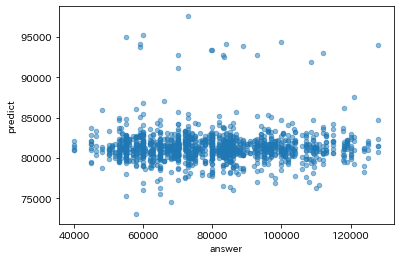

In [35]:
result_df.plot.scatter(x='answer', y='predict', alpha=0.5)

In [36]:
len(result_df)

1298